<div class="alert alert-info">
    <h1>Do We Need to Adjust for Single-Scattering and Shadowing?</h1>
Robert S. French, rfrench@seti.org - Last updated April 28, 2023

<h2>The Problem</h2>

<ul>
<li>French (2012) plotted low-phase angle (&lt; 60 degrees) Normal EWs and found that observations taken with
    the emission angle or incidence angle within 6 degrees of the ring plane were systematically less
    bright than other observation (see their Figure 6a).</li>
    
<li>French (2012) used this as justification for needing to adjust all measurements for single-scattering
    and shadowing using formulas from Chandrasekhar (see their Appendix).</li>
    
<li>By minimizing the scatter of all points around a log-cubic phase curve (with the large clump of 2006 removed), they derived an "equivalent tau" optical depth of 0.033. All measurements were adjusted using the Chandrasekhar formula based on this tau.</li>
    
<li>The end result was that the ring appeared brighter, because accounting for single-scattering and shadowing
    made each point brighter.</li>
    
<li><b>Do we still need to do this?</b></li>
</ul>
    
<h2>Methodology</h2>

<ol>
<li>Reproduce Fig 6a using original 2012 data to verify reproduceability. Also optimize for tau.</li>
    
<li>Reproduce Fig 6a using original 2012 data adjusted for known differences in calibration to see if the new calibration is primarily responsible for the observed effect. Also optimize for tau.</li>

<li>Reproduce Fig 6a using new data (limited to 2012 observations) to see what changes the other processing changes caused. Also optimize for tau. If the calibration factors are accurate, we expect this to give the same answer as step 2.</li>

<li>Create a new equivalent figure using ALL new low-phase observations with means. Also optimize for tau.</li>

<li>Create a new equivalent figure using ALL new low-phase observations with 1-degree slices. Also optimize for tau.</li>
    
<li>Repeat experiment 4 using only observations (incidence or emission) more than 4 degrees from the ring plane.</li>

<li>Repeat experiment 5 using only observations (incidence or emission) more than 4 degrees from the ring plane.</li>
    
<li>Fit a phase curve for ALL new observations optimizing for tau.</li>

<li>Fit a phase curve for ALL new observations using 1-degree slices optimizing for tau.</li>

<li>Repeat experiment 8 using only observations (incidence or emission) more than 4 degrees from the ring plane.</li>

<li>Repeat experiment 9 using only observations (incidence or emission) more than 4 degrees from the ring plane.</li>

<li>Using the full-data phase curve, plot EW 1-Degree Slices/Phase Curve vs. Mu and Mu0 and look for trends.</li>

<li>Using the full-data phase curve and phase angles < 60, plot EW 1-Degree Slices/Phase Curve vs. Mu and Mu0 and look for trends.</li>
    
<li>Decide if the adjustment is still required.</li>
</ul>
</div>

# Read Data and Initialize Data Structures

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import sys
if '..' not in sys.path: sys.path.append('..'); sys.path.append('../external')

from f_ring_util.f_ring import (add_cisscal_ratios,
                                add_hover,
                                compute_corrected_ew_col,
                                find_common_data_2012,
                                fit_hg_phase_function,
                                hg_func,
                                limit_by_quant,
                                print_hg_params,
                                read_cassini_ew_stats)

%matplotlib notebook

In [2]:
### PLOTTING AND OPTIMIZATION

def _standard_alpha(obsdata):
    """Return alpha based on number of points to plot."""
    if len(obsdata) < 1000:
        return 1
    elif len(obsdata) < 10000:
        return 0.6
    else:
        return 0.3
        
def compare_tau_no_tau_60(obsdata, col='Normal EW Mean', small_plot=False):
    low_phase = obsdata['Mean Phase'] <= 60
    low_phase_obsdata = obsdata[low_phase]
    low_e = np.abs(low_phase_obsdata['Mean Emission'].to_numpy()-90) < 6
    low_i = np.abs(low_phase_obsdata['Incidence'].to_numpy()-90) < 6
    low_ei = low_e | low_i

    best_tau = None
    best_ratio = 1e38
    for tau in np.arange(0, 0.04, 0.001):
        corrected_ew = compute_corrected_ew_col(low_phase_obsdata, col_tau=(col, tau))
        mean_low_tau = np.mean(corrected_ew[low_ei])
        mean_notlow_tau = np.mean(corrected_ew[~low_ei])
        ratio = mean_low_tau / mean_notlow_tau
        if (1/ratio if ratio < 1 else ratio) < (1/best_ratio if best_ratio < 1 else best_ratio):
            best_ratio = ratio
            best_tau = tau
#         print(f'{tau:.3f}: {ratio:.5f}')
#     print()

    mean_low = np.mean(low_phase_obsdata[col][low_ei])
    mean_notlow = np.mean(low_phase_obsdata[col][~low_ei])
    print('NO TAU:')
    print(f'Mean Normal EW low E/I: {mean_low:.3f}')
    print(f'Mean Normal EW Other:   {mean_notlow:.3f}')
    print(f'Ratio:                       {mean_low/mean_notlow:.3f}')
    print()
    print(f'BEST TAU: {best_tau:.3f}: Ratio {best_ratio:.5f}')

    corrected_ew = compute_corrected_ew_col(low_phase_obsdata, col_tau=(col, best_tau))
    
    if best_tau != 0:
        mean_low_tau = np.mean(corrected_ew[low_ei])
        mean_notlow_tau = np.mean(corrected_ew[~low_ei])
        print()
        print(f'Mean Normal EW low E/I: {mean_low_tau:.3f}')
        print(f'Mean Normal EW Other:   {mean_notlow_tau:.3f}')
        print(f'Ratio:                       {mean_low_tau/mean_notlow_tau:.3f}')
        print()
        overall_ratio = np.mean(corrected_ew) / np.mean(low_phase_obsdata[col])
        print(f'Overall Tau/no-Tau ratio: {overall_ratio:.3f}')

    if small_plot:
        fig, ax = plt.subplots(2, 1, figsize=(9,8))
    else:
        fig, ax = plt.subplots(1, 2, figsize=(9,4))
    if small_plot:
        p1 = ax[0].scatter(low_phase_obsdata['Mean Phase'][low_ei], 
                           low_phase_obsdata[col][low_ei], s=3, alpha=0.3, c='red', label='Low e or i')
        p2 = ax[0].scatter(low_phase_obsdata['Mean Phase'][~low_ei],
                           low_phase_obsdata[col][~low_ei], s=3, alpha=0.3, c='blue', label='Other')
    else:
        p1 = ax[0].scatter(low_phase_obsdata['Mean Phase'][low_ei], 
                           low_phase_obsdata[col][low_ei], c='red', label='Low e or i')
        p2 = ax[0].scatter(low_phase_obsdata['Mean Phase'][~low_ei],
                           low_phase_obsdata[col][~low_ei], c='blue', label='Other')
    add_hover(low_phase_obsdata[low_ei], p1, low_phase_obsdata[~low_ei], p2)
    ax[0].set_xlim(10,60)
    if not small_plot:
        ax[0].set_ylim(0.4,0.85)
    ax[0].legend(loc='upper left')
    ax[0].set_xlabel('Phase Angle (°)')
    ax[0].set_ylabel(col)
    ax[0].set_title('(no tau)')

    if small_plot:
        p1 = ax[1].scatter(low_phase_obsdata['Mean Phase'][low_ei], 
                           corrected_ew[low_ei], s=3, alpha=0.3, c='red', label='Low e or i')
        p2 = ax[1].scatter(low_phase_obsdata['Mean Phase'][~low_ei],
                           corrected_ew[~low_ei], s=3, alpha=0.3, c='blue', label='Other')
    else:
        p1 = ax[1].scatter(low_phase_obsdata['Mean Phase'][low_ei], 
                           corrected_ew[low_ei], c='red', label='Low e or i')
        p2 = ax[1].scatter(low_phase_obsdata['Mean Phase'][~low_ei],
                           corrected_ew[~low_ei], c='blue', label='Other')
    add_hover(low_phase_obsdata[low_ei], p1, low_phase_obsdata[~low_ei], p2)
    ax[1].set_xlim(10, 60)
    if not small_plot:
        ax[1].set_ylim(0.4, 0.85)
    ax[1].legend(loc='upper left')
    ax[1].set_xlabel('Phase Angle (°)')
    ax[1].set_ylabel(col)
    ax[1].set_title(f'(tau={best_tau:.3f})')
    plt.tight_layout()
    return best_tau
    
def optimize_phase_tau(obsdata, col='Normal EW Mean', small_plot=False, force_tau=None):
    base_params, _, base_std = fit_hg_phase_function(2, None, obsdata, col_tau=(col, None))
    best_tau = None
    best_params = None
    best_std = 1e38
    for tau in np.arange(0, 0.01, 0.001):
        params, _, std = fit_hg_phase_function(2, None, obsdata, col_tau=(col, tau))
        if std < best_std:
            best_std = std
            best_params = params
            best_tau = tau
#         print(f'{tau:.3f}: {std:.7f}')
#     print()

    print('NO TAU:')
    print_hg_params(base_params)
    print()
    print(f'BEST TAU: {best_tau:.3f}')
    print_hg_params(best_params)
    print(f'Base std: {base_std:.7f}')
    print(f'Best std: {best_std:.7f}')
    ratios = [best_params[i*2+1]/base_params[i*2+1] for i in range(len(base_params)//2)]
    ratio_mean = np.mean(ratios)
    ratios_str = ' '.join([f'{x:.3f}' for x in ratios])
    print(f'Best/no tau scale ratios: {ratios_str}  mean={ratio_mean:.3f}')
    
    corrected_ew = compute_corrected_ew_col(obsdata, col_tau=(col, best_tau))
    xrange = np.arange(obsdata['Mean Phase'].min(), obsdata['Mean Phase'].max()+1)

    if force_tau is not None:
        force_params, _, force_std = fit_hg_phase_function(2, None, obsdata, col_tau=(col, force_tau))
        print()
        print(f'FORCE TAU: {force_tau:.3f}')
        print_hg_params(force_params)
        print(f'Force std: {force_std:.7f}')
        ratios = [force_params[i*2+1]/base_params[i*2+1] for i in range(len(force_params)//2)]
        ratio_mean = np.mean(ratios)
        ratios_str = ' '.join([f'{x:.3f}' for x in ratios])
        print(f'Force/no tau scale ratios: {ratios_str}  mean={ratio_mean:.3f}')
        force_corrected_ew = compute_corrected_ew_col(obsdata, col_tau=(col, force_tau))

    nplots = 2 if force_tau is None else 3
    if small_plot:
        fig, ax = plt.subplots(nplots, 1, figsize=(9,8))
    else:
        fig, ax = plt.subplots(1, nplots, figsize=(9,4))
    if small_plot:
        p1 = ax[0].scatter(obsdata['Mean Phase'], obsdata[col], s=3, alpha=0.3, c='black')
    else:
        p1 = ax[0].scatter(obsdata['Mean Phase'], obsdata[col], c='black')
    add_hover(obsdata, p1)
    full_phase_model = hg_func(base_params, xrange)
    ax[0].plot(xrange, full_phase_model, '-', color='green', lw=2)
    ax[0].set_xlim(0, 180)
    ax[0].set_xlabel('Phase Angle (°)')
    ax[0].set_ylabel(col)
    ax[0].set_yscale('log')
    ax[0].set_title('(no tau)')

    if small_plot:
        p1 = ax[1].scatter(obsdata['Mean Phase'], corrected_ew, s=3, alpha=0.3, c='black')
    else:
        p1 = ax[1].scatter(obsdata['Mean Phase'], corrected_ew, c='black')
    add_hover(obsdata, p1)
    full_phase_model = hg_func(best_params, xrange)
    ax[1].plot(xrange, full_phase_model, '-', color='green', lw=2)
    ax[1].set_xlim(0, 180)
    ax[1].set_xlabel('Phase Angle (°)')
    ax[1].set_ylabel(col)
    ax[1].set_yscale('log')
    ax[1].set_title(f'(tau={best_tau:.3f})')
    
    if force_tau is not None:
        if small_plot:
            p1 = ax[2].scatter(obsdata['Mean Phase'], force_corrected_ew, s=3, alpha=0.3, c='black')
        else:
            p1 = ax[2].scatter(obsdata['Mean Phase'], force_corrected_ew, c='black')
        add_hover(obsdata, p1)
        full_phase_model = hg_func(force_params, xrange)
        ax[2].plot(xrange, full_phase_model, '-', color='green', lw=2)
        ax[2].set_xlim(0, 180)
        ax[2].set_xlabel('Phase Angle (°)')
        ax[2].set_ylabel(col)
        ax[2].set_yscale('log')
        ax[2].set_title(f'(tau={force_tau:.3f})')
        
    plt.tight_layout()
    return best_tau


### SINGLE PLOTS ON AN AXIS - RATIOS

def plot_ratio_vs(obsdata, params, vs, color_by, order, ax=None):
    """Plot scattered used/unused EW points vs. another parameter."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))

    obsdata['Phase Model'] = hg_func(params, obsdata['Mean Phase'])
    obsdata['Phase Curve Ratio'] = obsdata['Normal EW Mean'] / obsdata['Phase Model']
    
    alpha = _standard_alpha(obsdata)
    p = ax.scatter(obsdata[vs], obsdata['Phase Curve Ratio'], marker='o', 
                   s=5, c=obsdata[color_by], cmap=cm.jet, alpha=alpha)
    add_hover(obsdata, p)

    coeff = np.polyfit(obsdata[vs], obsdata['Phase Curve Ratio'], order)
    xrange = np.linspace(obsdata[vs].min(), obsdata[vs].max(), 100, endpoint=True)
    fit = np.polyval(coeff, xrange)
    ax.plot(xrange, fit, '-', lw=2, color='green')

    ax.set_yscale('log')
    ax.set_xlabel(vs)
    ax.set_ylabel('Normal EW / Full Phase Model')

def plot_ratio_vs_mu_mu0(obsdata, params, title, color_by='Mean Phase', order=3):
    """Plot 1) NEW/Model vs Mu 2) NEW/Model vs Mu0."""
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))
    plot_ratio_vs(obsdata, params, vs='Mu', color_by=color_by, order=order, ax=axs[0])
    plot_ratio_vs(obsdata, params, vs='Mu0', color_by=color_by, order=order, ax=axs[1])
    plt.suptitle(title)
    plt.tight_layout()


In [3]:
obsdata_60_0 = read_cassini_ew_stats('../data_files/cass_ew_60_0.csv')
print()
obsdata_0_1 = read_cassini_ew_stats('../data_files/cass_ew_0_1.csv')
print()

# Find the intersection of the old and new data
commondata = find_common_data_2012(obsdata_60_0)

# Add CISSCAL ratios
commondata = add_cisscal_ratios(commondata)

commondata33 = commondata.loc[:'ISS_041RF_FMOVIE002_VIMS']
commondata36 = commondata.loc['ISS_044RF_FMOVIE001_VIMS':]

** SUMMARY STATISTICS - ../data_files/cass_ew_60_0.csv **
Unique observation names: 155
Total slices: 155
Starting date: 2004-06-20 19:15:28
Ending date: 2017-09-06 11:47:07
Time span: 4825 days 16:31:39

** SUMMARY STATISTICS - ../data_files/cass_ew_0_1.csv **
Unique observation names: 210
Total slices: 38454
Starting date: 2004-06-20 19:15:28
Ending date: 2017-09-07 21:51:55
Time span: 4827 days 02:36:27

Total number of new observation names: 155
Total number of observation names from 2012: 25
Number of observation names in common: 23
Missing observation names: {'ISS_036RF_FMOVIE002_VIMS', 'ISS_007RI_LPHRLFMOV001_PRIME'}


# 1. Reproduce Figure 6a Using 2012 Data Means; Compute Tau

** USING 2012 ORIGINAL DATA **
NO TAU:
Mean Normal EW low E/I: 0.548
Mean Normal EW Other:   0.577
Ratio:                       0.949

BEST TAU: 0.019: Ratio 0.99902

Mean Normal EW low E/I: 0.637
Mean Normal EW Other:   0.638
Ratio:                       0.999

Overall Tau/no-Tau ratio: 1.134


<IPython.core.display.Javascript object>


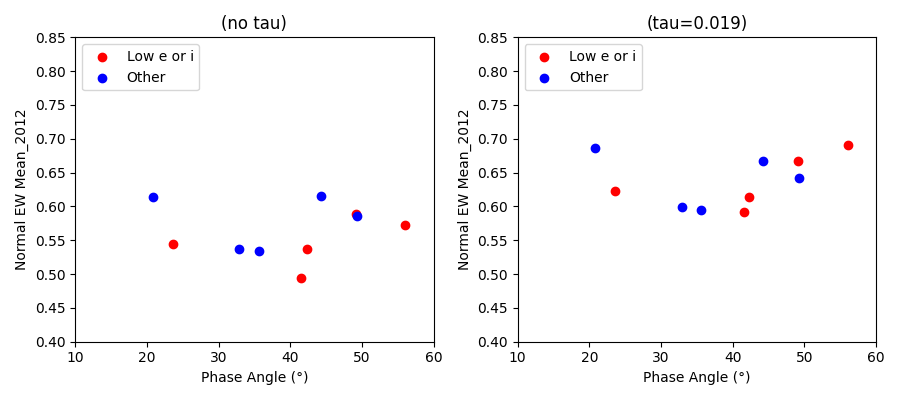

In [4]:
print('** USING 2012 ORIGINAL DATA **')
_=compare_tau_no_tau_60(commondata, col='Normal EW Mean_2012')

# 2. Reproduce Figure 6a Using Calibration-Adjusted Measurements of 2012 Data Means; Compute Tau

USING 2012 ORIGINAL DATA ADJUSTED FOR KNOWN CALIBRATION CHANGES
NO TAU:
Mean Normal EW low E/I: 0.532
Mean Normal EW Other:   0.549
Ratio:                       0.968

BEST TAU: 0.011: Ratio 0.99890

Mean Normal EW low E/I: 0.581
Mean Normal EW Other:   0.582
Ratio:                       0.999

Overall Tau/no-Tau ratio: 1.076


<IPython.core.display.Javascript object>


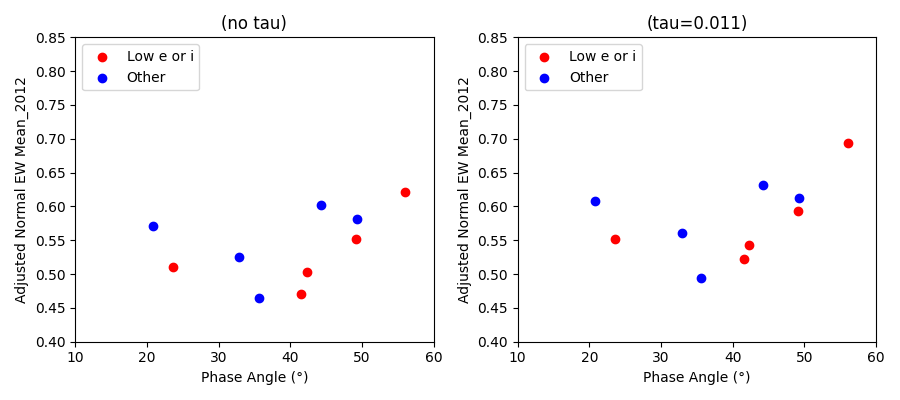

In [5]:
print('USING 2012 ORIGINAL DATA ADJUSTED FOR KNOWN CALIBRATION CHANGES')
_=compare_tau_no_tau_60(commondata, col='Adjusted Normal EW Mean_2012')

# 3. Reproduce Figure 6a Using New Data Means Limited to 2012 Observations; Compute Tau

USING NEW DATA LIMITED TO 2012 OBSERVATIONS
NO TAU:
Mean Normal EW low E/I: 0.525
Mean Normal EW Other:   0.526
Ratio:                       0.999

BEST TAU: 0.000: Ratio 0.99894


<IPython.core.display.Javascript object>


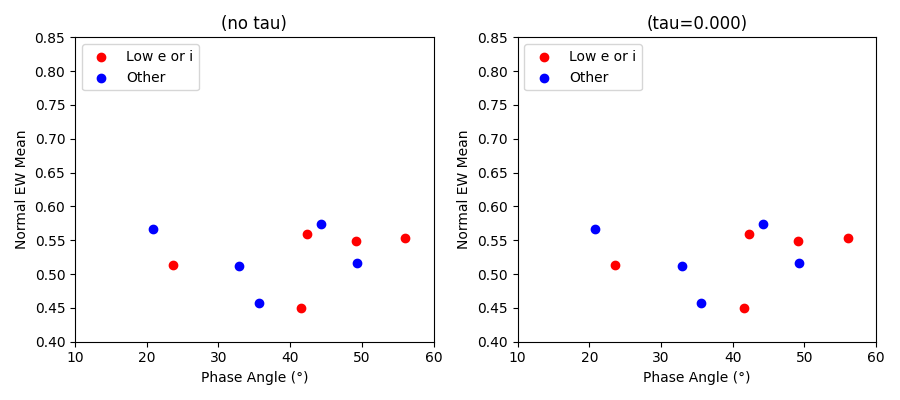

In [6]:
print('USING NEW DATA LIMITED TO 2012 OBSERVATIONS')
_=compare_tau_no_tau_60(commondata)

<div class="alert alert-info">
<h2>Summary</h2>
    
<b>The original data from 2012 prefers tau=0.019. However, when it is corrected for known calibration changes, this drops to tau=0.011. Using the new data for the same set of observations reduces this further to tau=0.000.</b>

<b>There is only a single observation in the CISSCAL 3.3 range (ISS_006RI) so we wouldn't actually expect the results of steps 1 and 2 to be very different; they are only corrected by the per-image calibration measurements. However, our measurements of CISSCAL 3.3 and 3.6 per-image calibration factor are not very precise. This is further shown in the fact that the results of steps 2 and 3 do not agree, even though we would expect them to.</b>
    
<b>Given that the new measurements result in tau=0.000, it appears that the higher values of tau were the result of calibration issues, not the result of actual observational differences.</b>
    
</div>

# 4. Reproduce Figure 6a Using ALL New Data Means; Compute Tau

USING ALL NEW LOW-PHASE DATA
NO TAU:
Mean Normal EW low E/I: 0.524
Mean Normal EW Other:   0.585
Ratio:                       0.895

BEST TAU: 0.013: Ratio 1.00013

Mean Normal EW low E/I: 0.612
Mean Normal EW Other:   0.612
Ratio:                       1.000

Overall Tau/no-Tau ratio: 1.105


<IPython.core.display.Javascript object>


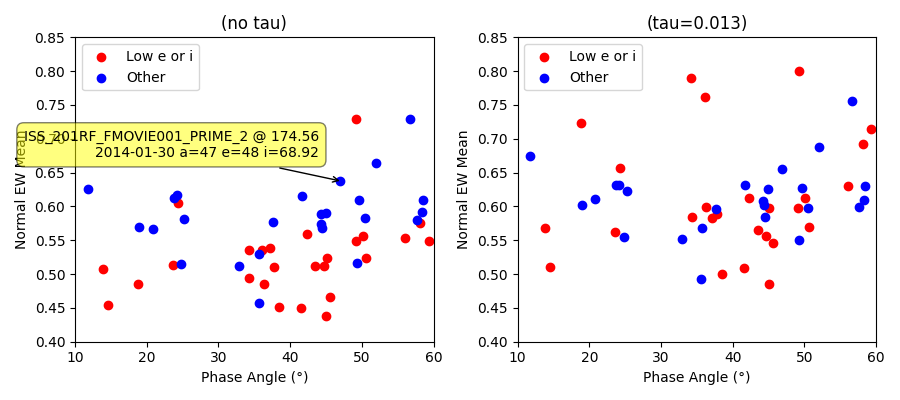

In [7]:
print('USING ALL NEW LOW-PHASE DATA')
best_low_phase_tau = compare_tau_no_tau_60(obsdata_60_0)

# 5. Reproduce Figure 6a Using ALL New Data 1-Degree Slices; Compute Tau

USING ALL NEW LOW-DATA DATA WITH 1-DEGREE SLICES
NO TAU:
Mean Normal EW low E/I: 0.531
Mean Normal EW Other:   0.584
Ratio:                       0.910

BEST TAU: 0.013: Ratio 1.00359

Mean Normal EW low E/I: 0.614
Mean Normal EW Other:   0.612
Ratio:                       1.004

Overall Tau/no-Tau ratio: 1.094


<IPython.core.display.Javascript object>


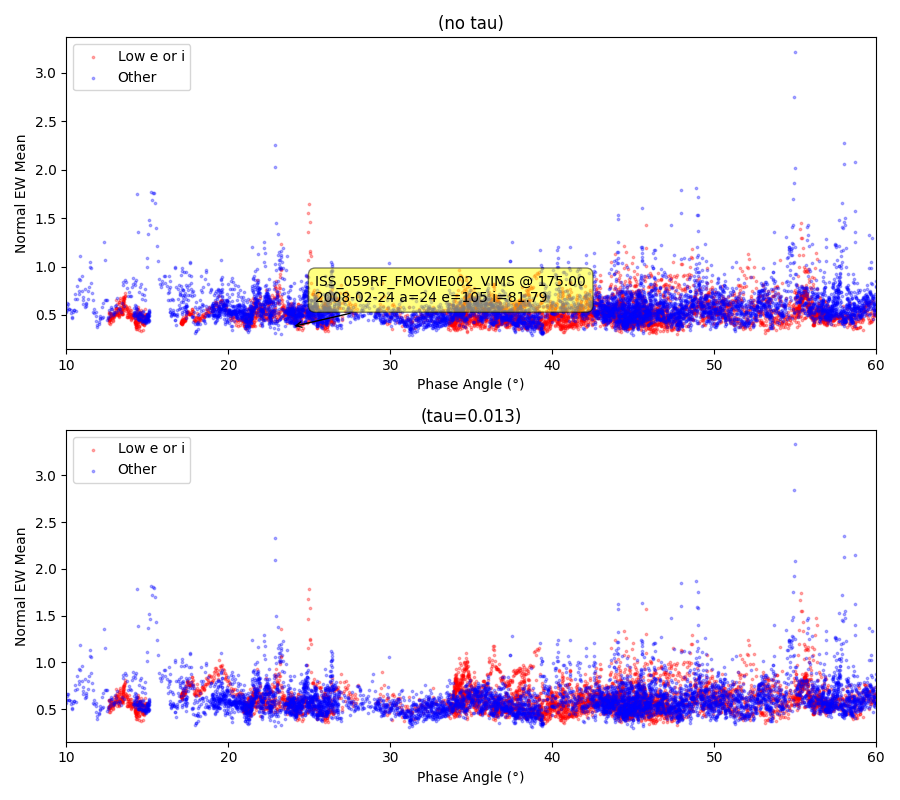

In [8]:
print('USING ALL NEW LOW-DATA DATA WITH 1-DEGREE SLICES')
_=compare_tau_no_tau_60(obsdata_0_1, small_plot=True)

# 6. Reproduce Figure 6a Using ALL New Data Means (i < 86); Compute Tau

USING ALL NEW LOW-PHASE DATA
NO TAU:
Mean Normal EW low E/I: 0.534
Mean Normal EW Other:   0.585
Ratio:                       0.912

BEST TAU: 0.024: Ratio 1.00068

Mean Normal EW low E/I: 0.636
Mean Normal EW Other:   0.636
Ratio:                       1.001

Overall Tau/no-Tau ratio: 1.124


<IPython.core.display.Javascript object>


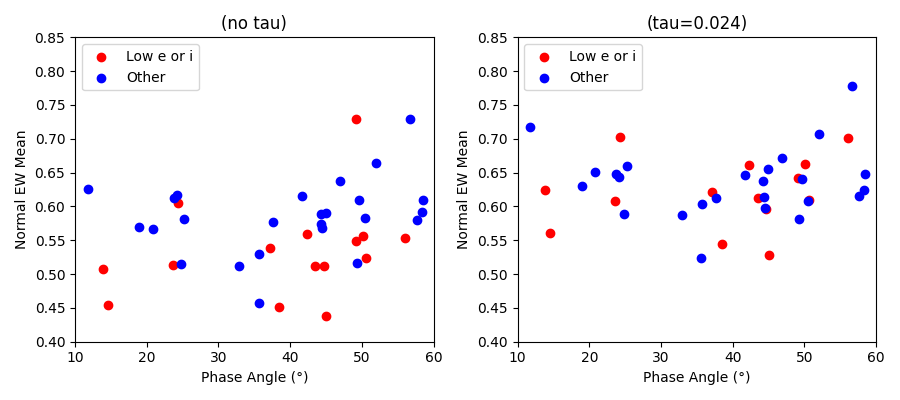

In [9]:
print('USING ALL NEW LOW-PHASE DATA')
high_ei_obsdata_60_0 = obsdata_60_0[((obsdata_60_0['Mean Emission']-90).abs() >= 4) & ((obsdata_60_0['Incidence']-90).abs() >= 4)]
high_ei_obsdata_0_1 = obsdata_0_1[((obsdata_0_1['Mean Emission']-90).abs() >= 4) & ((obsdata_0_1['Incidence']-90).abs() >= 4)]
best_low_phase_high_ei_tau = compare_tau_no_tau_60(high_ei_obsdata_60_0)

# 7. Reproduce Figure 6a Using ALL New Data 1-Degree Slices (i < 86); Compute Tau

USING ALL NEW LOW-DATA DATA WITH 1-DEGREE SLICES
NO TAU:
Mean Normal EW low E/I: 0.549
Mean Normal EW Other:   0.584
Ratio:                       0.941

BEST TAU: 0.017: Ratio 1.00164

Mean Normal EW low E/I: 0.622
Mean Normal EW Other:   0.621
Ratio:                       1.002

Overall Tau/no-Tau ratio: 1.086


<IPython.core.display.Javascript object>


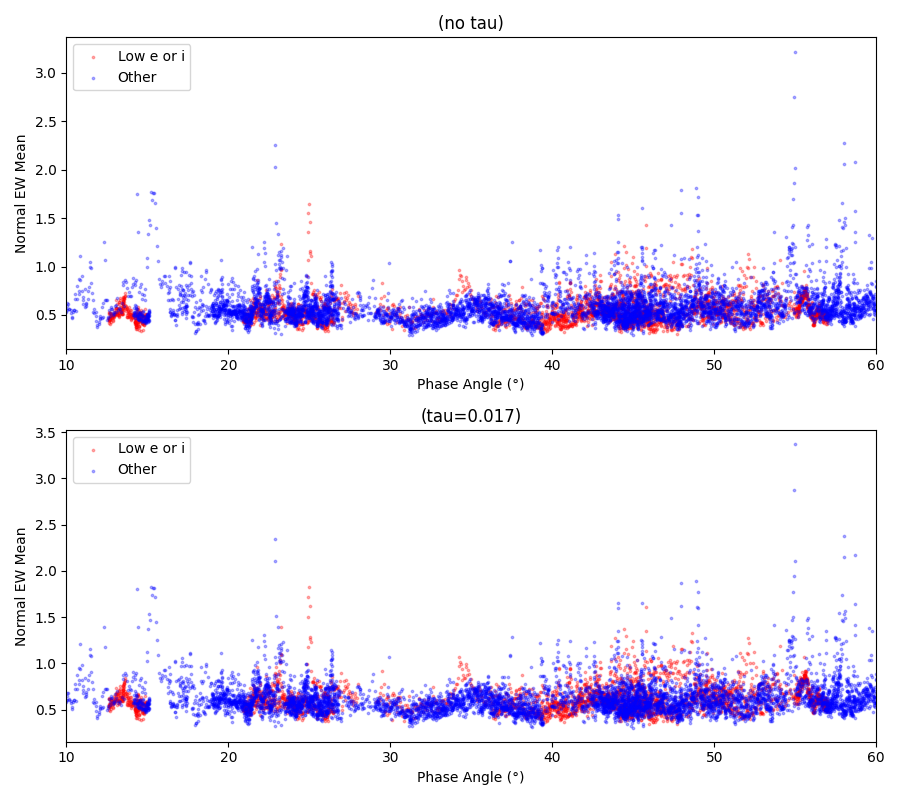

In [10]:
print('USING ALL NEW LOW-DATA DATA WITH 1-DEGREE SLICES')
_=compare_tau_no_tau_60(high_ei_obsdata_0_1, small_plot=True)

<div class="alert alert-info">
<h2>Summary</h2>
    
<b>Using all available low-phase data, there is a preference for tau=0.013. However, while this does make the means of the two data sets equal, the amount of scatter in the low-e/i group increases dramatically. This implies that this is not actually a good choice for tau, because ideally we would like the amount of scatter to decrease. Looking at the data points that change the most, they appear to be primarily at incidence angles very close to 90. This implies that the Chandrasekhar formula is not doing a good job of manipulating data at those extremes.</b>
    
<b>Repeating the experiment with observations within 4 degrees of the ring plane removed, we see the scatter of the tau-adjusted points remain controlled, with preferred taus of 0.024 and 0.017. In the worst case, these result in an increase in brightness of ~12%.</b>
</div>

# 8. Optimize Tau and Phase Curve Using ALL New Data Means

NO TAU:
g1 = -0.653 / scale1 =  1.669 / weight1 = 0.643 
g2 = -0.026 / scale2 =  0.927 / weight2 = 0.357  Avg scale 1.298

BEST TAU: 0.002
g1 = -0.653 / scale1 =  1.680 / weight1 = 0.641 
g2 = -0.025 / scale2 =  0.941 / weight2 = 0.359  Avg scale 1.311
Base std: 0.0543218
Best std: 0.0535637
Best/no tau scale ratios: 1.007 1.015  mean=1.011


<IPython.core.display.Javascript object>


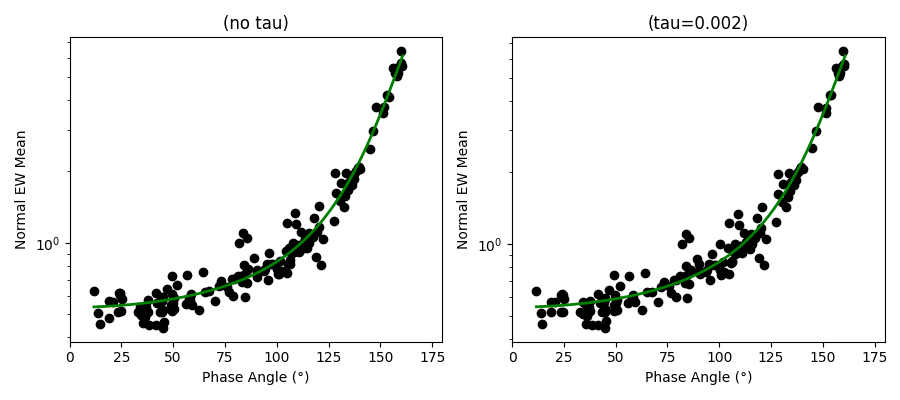

In [11]:
_=optimize_phase_tau(obsdata_60_0)

# 9. Optimize Tau and Phase Curve Using ALL New Data 1-Degree Slices

NO TAU:
g1 = -0.657 / scale1 =  1.643 / weight1 = 0.628 
g2 = -0.035 / scale2 =  0.972 / weight2 = 0.372  Avg scale 1.308

BEST TAU: 0.001
g1 = -0.657 / scale1 =  1.646 / weight1 = 0.626 
g2 = -0.036 / scale2 =  0.982 / weight2 = 0.374  Avg scale 1.314
Base std: 0.1122525
Best std: 0.1119187
Best/no tau scale ratios: 1.002 1.010  mean=1.006

FORCE TAU: 0.013
g1 = -0.664 / scale1 =  1.653 / weight1 = 0.589 
g2 = -0.053 / scale2 =  1.153 / weight2 = 0.411  Avg scale 1.403
Force std: 0.1249156
Force/no tau scale ratios: 1.006 1.185  mean=1.096


<IPython.core.display.Javascript object>


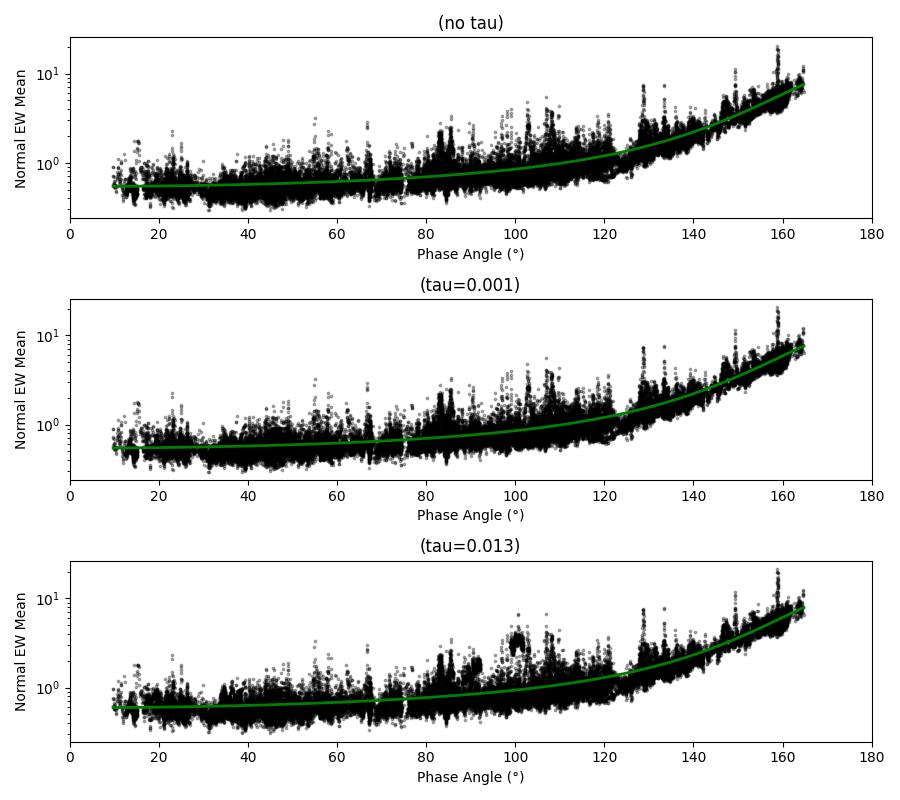

In [12]:
_=optimize_phase_tau(obsdata_0_1, small_plot=True, force_tau=best_low_phase_tau)

<div class="alert alert-info">
<h2>Summary</h2>
    
<b>Optimizing tau for the entire data set, we find a preference for tau=0.001 or 0.002, both of which are negligible. Forcing tau to be 0.013, the best found for low phase, causes a significant reduction in goodness of fit to the phase curve.</b>
</div>

# 10. Optimize Tau and Phase Curve Using ALL New Data Means (i < 86)

In [13]:
high_ei_obsdata_60_0 = obsdata_60_0[((obsdata_60_0['Mean Emission']-90).abs() >= 4) & ((obsdata_60_0['Incidence']-90).abs() >= 4)]
high_ei_obsdata_0_1 = obsdata_0_1[((obsdata_0_1['Mean Emission']-90).abs() >= 4) & ((obsdata_0_1['Incidence']-90).abs() >= 4)]

NO TAU:
g1 = -0.648 / scale1 =  1.700 / weight1 = 0.651 
g2 = -0.009 / scale2 =  0.912 / weight2 = 0.349  Avg scale 1.306

BEST TAU: 0.009
g1 = -0.646 / scale1 =  1.756 / weight1 = 0.654 
g2 =  0.002 / scale2 =  0.928 / weight2 = 0.346  Avg scale 1.342
Base std: 0.0555758
Best std: 0.0534489
Best/no tau scale ratios: 1.033 1.018  mean=1.025


<IPython.core.display.Javascript object>


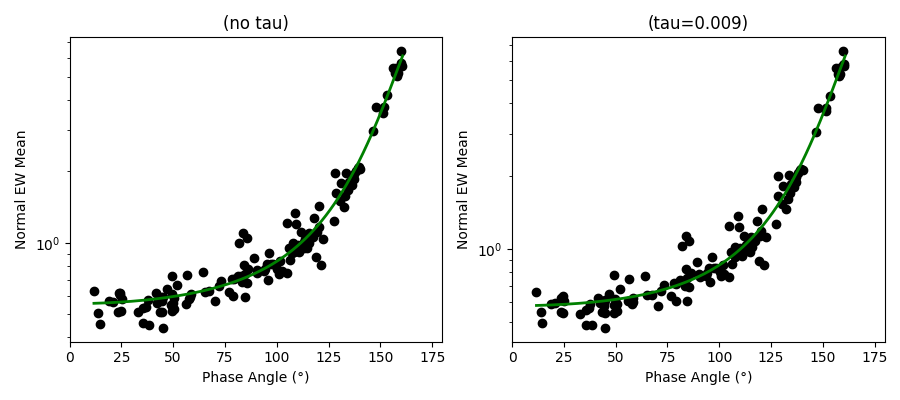

In [14]:
_=optimize_phase_tau(high_ei_obsdata_60_0)

# 11. Optimize Tau and Phase Curve Using ALL New Data 1-Degree Slices (i < 86)

NO TAU:
g1 = -0.653 / scale1 =  1.665 / weight1 = 0.632 
g2 = -0.023 / scale2 =  0.969 / weight2 = 0.368  Avg scale 1.317

BEST TAU: 0.009
g1 = -0.652 / scale1 =  1.717 / weight1 = 0.634 
g2 = -0.014 / scale2 =  0.989 / weight2 = 0.366  Avg scale 1.353
Base std: 0.1139227
Best std: 0.1130684
Best/no tau scale ratios: 1.031 1.021  mean=1.026

FORCE TAU: 0.013
g1 = -0.651 / scale1 =  1.740 / weight1 = 0.635 
g2 = -0.010 / scale2 =  0.998 / weight2 = 0.365  Avg scale 1.369
Force std: 0.1127944
Force/no tau scale ratios: 1.045 1.031  mean=1.038


<IPython.core.display.Javascript object>


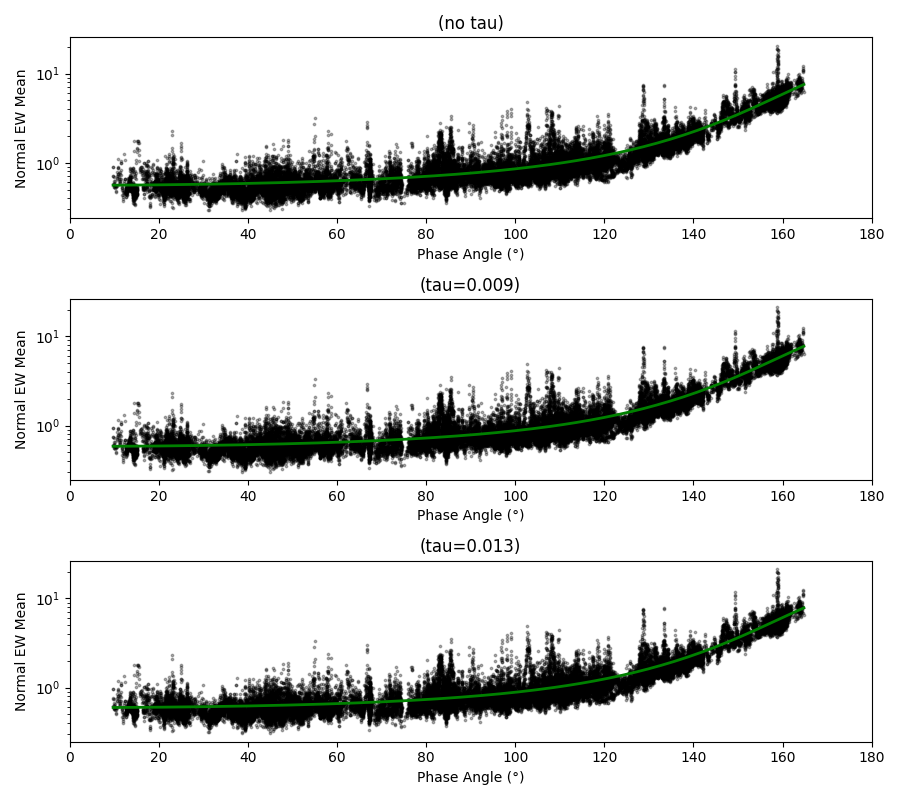

In [15]:
_=optimize_phase_tau(high_ei_obsdata_0_1, small_plot=True, force_tau=best_low_phase_tau)

<div class="alert alert-info">
<h2>Summary</h2>
    
<b>Removing very low incidence and emission angle observations, the preferred tau=0.009 with a change in brightness from tau=0 of only 3%, vs. tau=0.013 with a change of brightness of only 4%. Since, with the complete data set, the change in brightness at tau=0.013 is 10%, this shows that most of the change in brightness is caused by a small number of low-incidence and low-emission angle observations. We should consider removing these observations from our photometry dataset entirely.</b>
</div>

# 12. Plot EW / Phase Curve vs. Mu and Mu0 for 1-Degree Slices and ALL Phase Angles

In [16]:
cutoff = 100
obsdata_limited = limit_by_quant(obsdata_0_1, cutoff, None)
params_limited, _, _ = fit_hg_phase_function(2, None, obsdata_limited)
print(f'1 degree slices, {cutoff}% cutoff')
print_hg_params(params_limited)

1 degree slices, 100% cutoff
g1 = -0.657 / scale1 =  1.643 / weight1 = 0.628 
g2 = -0.035 / scale2 =  0.972 / weight2 = 0.372  Avg scale 1.308


<IPython.core.display.Javascript object>


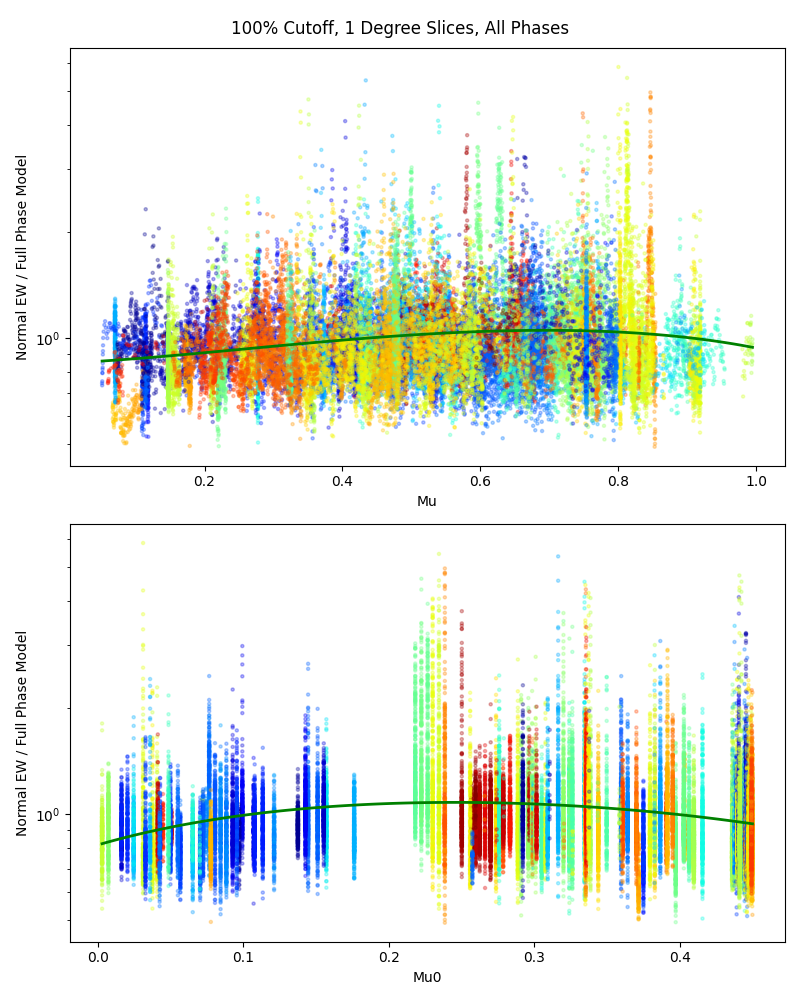

In [17]:
plot_ratio_vs_mu_mu0(obsdata_limited, params_limited, 
                     f'{cutoff}% Cutoff, 1 Degree Slices, All Phases', order=3)

# 13. Plot EW / Phase Curve vs. Mu and Mu0 for 1-Degree Slices and Phase Angles < 60

<IPython.core.display.Javascript object>


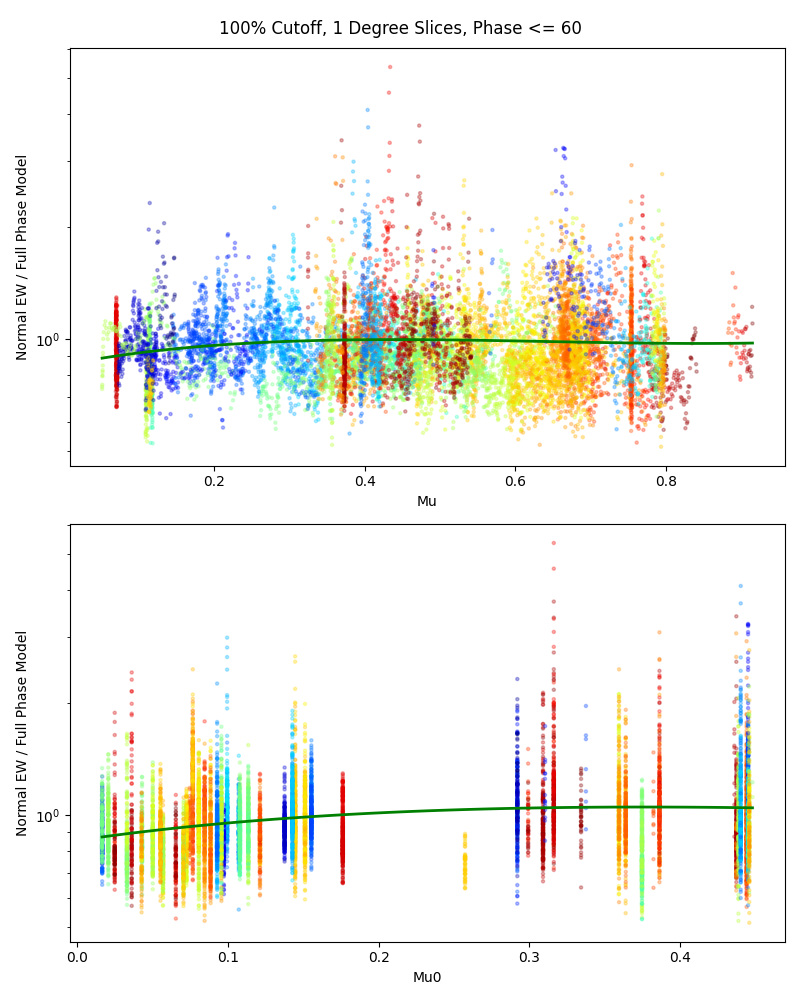

In [18]:
obsdata_limited_low_phase = obsdata_limited[obsdata_limited['Mean Phase'] <= 60].copy()
plot_ratio_vs_mu_mu0(obsdata_limited_low_phase, params_limited, 
                     f'{cutoff}% Cutoff, 1 Degree Slices, Phase <= 60', order=3)

<div class="alert alert-info">
<h2>Summary</h2>
    
<b>We do not see a compelling trend in phase-normalized brightness with either Mu or Mu0.</b>
</div>

<div class="alert alert-info">
<h2>Conclusion</h2>
    
<b>Evidence for the need for a tau-adjustment is inconsistent. Values of tau that improve low-phase (less than 60 degrees) observations increase scatter when looking at all phase angles. Optimizations of tau while fitting a phase curve result in very low values for tau (<= 0.002). Using phase-normalized EWs, there are no obvious trends of brightness with either Mu or Mu0.</b>
    
<b>As a result, we conclude that an adjustment for tau is not necessary, or at the very least that our adjustment model is insufficient to handle the data we have. It is possible a more sophisticated model would do a better job. We choose to not do any adjustment, and accept that the resulting brightness values may be in error on the order of 10%.</b>
</div>